16.512, Homework 7, Johannes Norheim, due 11/30

This pset was written in a jupyter notebooks, and has been uploaded online to https://github.com/norheim/rocketscience/blob/master/hw.ipynb

In [1]:
from scipy.optimize import fsolve

In [2]:
from pint import UnitRegistry
ureg = UnitRegistry()

In [3]:
h_LOX = 1.5e5 * ureg.J / ureg.kg # J/kg h_LOX
h_k = 4.2e5 * ureg.J / ureg.kg# J/kg h_k
h = 4.38e7 * ureg.J / ureg.kg 

Pc = 250 * ureg.atm
Ptk = 4 * ureg.atm
dP_PB = 3e6  * ureg.Pa# Pa
dP_inj = 2.5e6 * ureg.Pa
dP_cool = 5.06e6 * ureg.Pa

gamma = 1.35
cp = 1350 * ureg.J / ureg.kg / ureg.K

rho_LOX = 1140 * ureg.kg / ureg.m**3 # kg/m3 LOX
rho_k = 807 * ureg.kg / ureg.m**3 # kg/m3 fuel

r = 2.64

eta = 0.7
Tti = 1000 * ureg.K
mdot_LOX = 1792 * ureg.kg / ureg.s

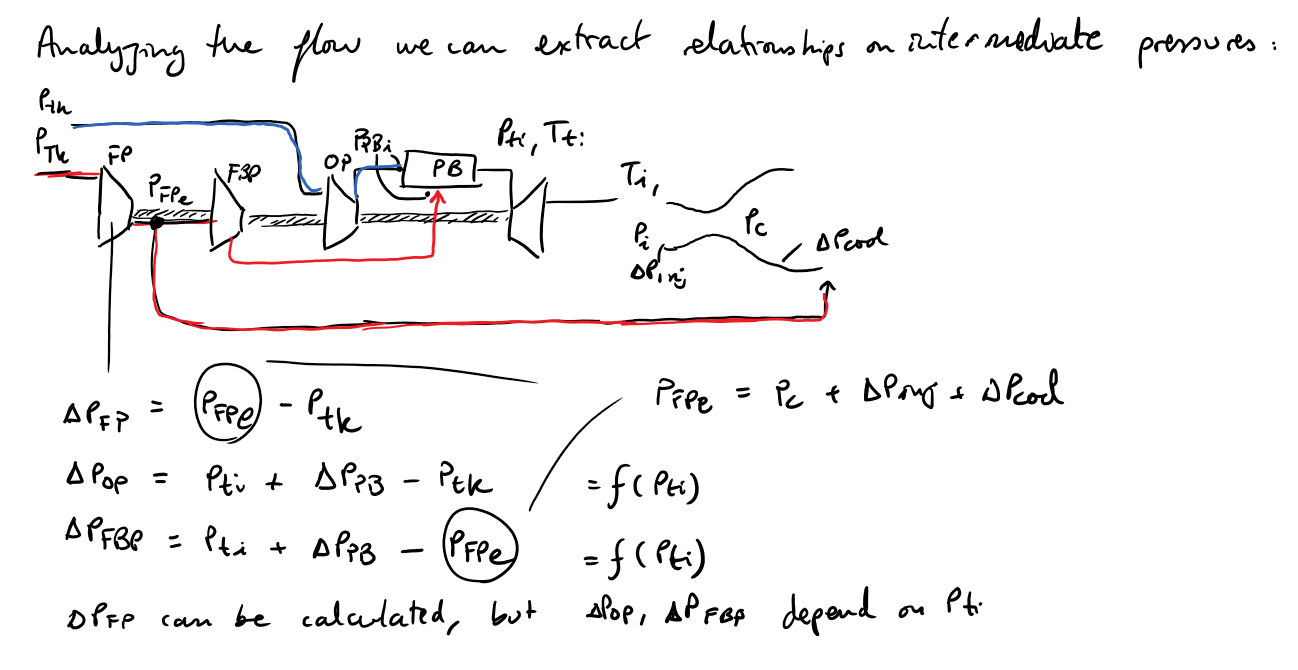

In [4]:
Pi = Pc + dP_inj
P_FPe = Pi + dP_cool
dP_FP = P_FPe - Ptk
dP_OP = lambda P_ti: P_ti + dP_PB - Ptk
dP_FBP = lambda P_ti: P_ti + dP_PB - P_FPe

In [5]:
dP_FP.to(ureg.Pa)

<Quantity(32485950.0, 'pascal')>

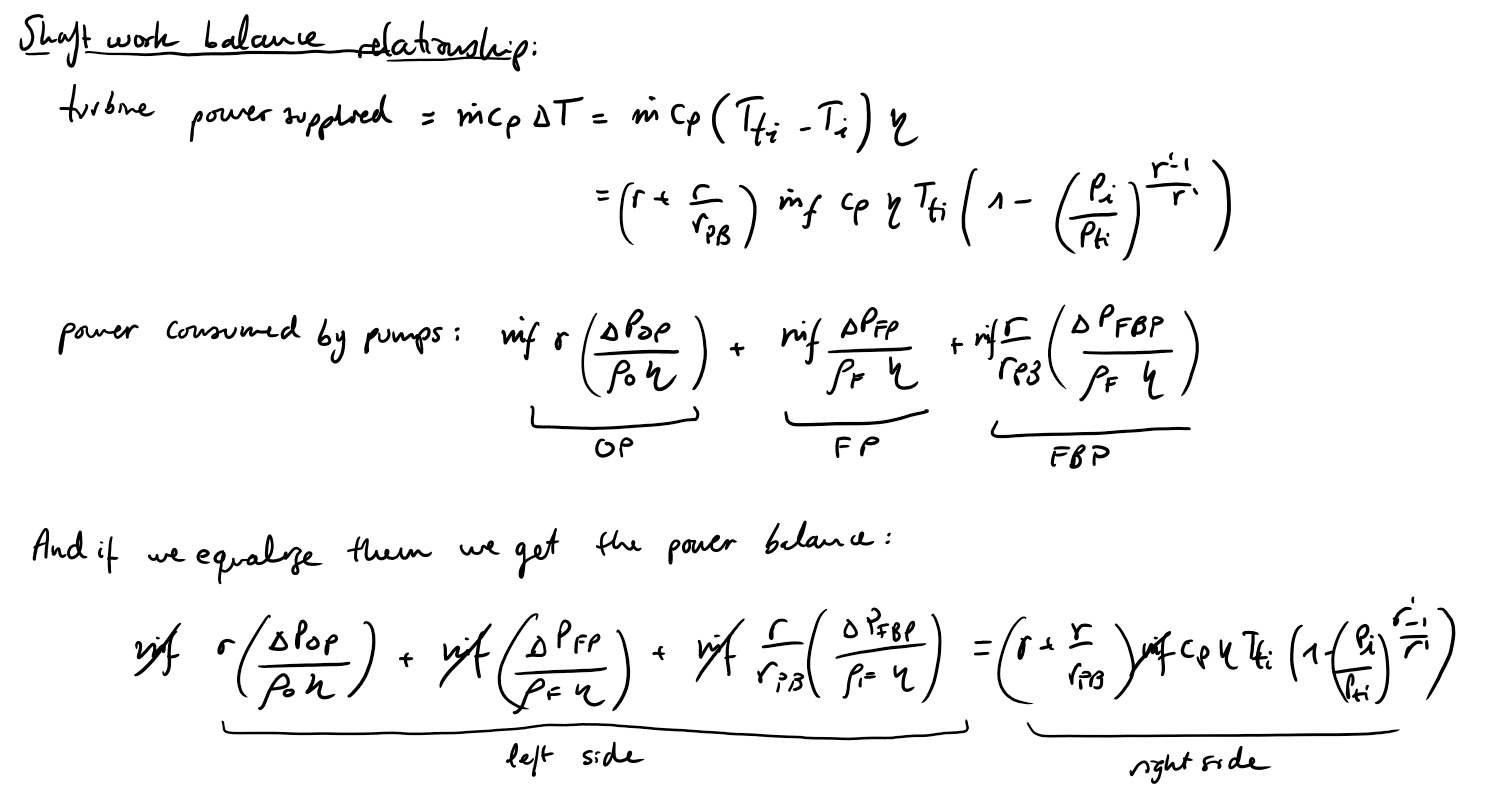

In [6]:
def work_balance(Pti, r_PB):
    right_side = (r+r/r_PB)*cp*Tti*eta*(1-(Pi/Pti)**((gamma-1)/gamma))
    left_side = r*dP_OP(Pti)/(eta*rho_LOX) + dP_FP/(eta*rho_k) + r/r_PB*dP_FBP(Pti)/(eta*rho_k)
    return left_side - right_side

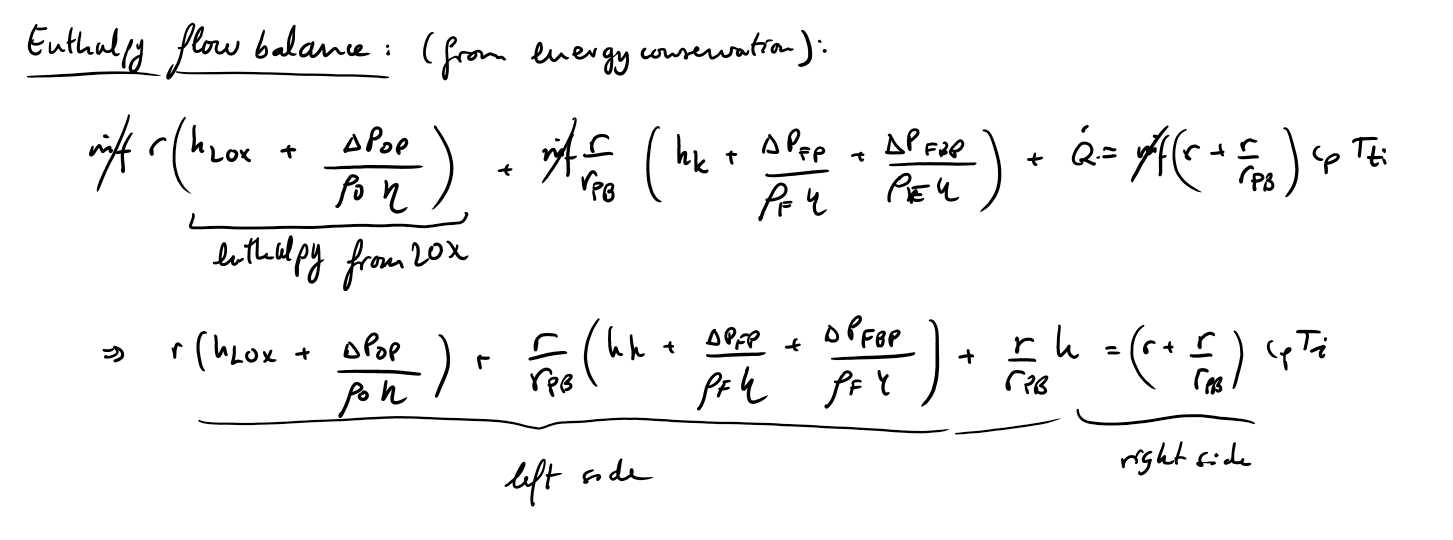

In [7]:
def energy_balance(Pti, r_PB):
    left_side = r*(h_LOX + dP_OP(Pti)/(eta*rho_LOX)) + r/r_PB*(h_k + dP_FP/(eta*rho_k) + dP_FBP(Pti)/(eta*rho_k)) + r/r_PB*h
    right_side = (r+r/r_PB)*cp*Tti
    return left_side-right_side

We setup the functions to use them with a numerical solver:

In [8]:
def total_balance(x):
    Pti_atm, r_PB = x
    Pti = Pti_atm * ureg.atm
    return work_balance(Pti, r_PB).magnitude, energy_balance(Pti, r_PB).magnitude

We use an initial guess with a pressue larger than P_FPe, so 324 atm, and a large enough value for r_PB to run a small fraction of the fuel into the pre-burner.

In [9]:
Pti_atm_sol, r_PB_sol  = fsolve(total_balance, [324, 20])

In [10]:
Pti_sol = Pti_atm_sol*ureg.atm

In [11]:
'r_PB = {r_PB}'.format(r_PB=r_PB_sol)

'r_PB = 37.3496556881'

We can then calculate the pressure at exit points

In [12]:
'Pressure at OP exit: {p}'.format(p=(dP_OP(Pti_sol) + Ptk))

'Pressure at OP exit: 400.113256489 atmosphere'

In [13]:
'Pressure at FP exit: {p}'.format(p=(dP_FP + Ptk))

'Pressure at FP exit: 324.611398964 atmosphere'

In [14]:
'Pressure at FBP exit: {p}'.format(p=(dP_FBP(Pti_sol) + dP_FP+Ptk))

'Pressure at FBP exit: 400.113256489 atmosphere'

Turbine power:

In [15]:
power = mdot_LOX * cp * (r+r/r_PB_sol) * eta * Tti * (1-(Pi/Pti_sol)**((gamma-1)/gamma))

In [16]:
power.to(ureg.MW)

<Quantity(342.712843257, 'megawatt')>